# Training Model 2

- 6 gambar (sample) -> feature extraction + mlp -> 6 output

In [1]:
# import library 

import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skew
from skimage.feature import greycomatrix, greycoprops

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

- create folder for original dataset

In [21]:
if not os.path.exists("Original_Dataset_Tomat/") :
    os.mkdir("Original_Dataset_Tomat")
if not os.path.exists("Original_Dataset_Test/") :
    os.mkdir("Original_Dataset_Test")
    if not os.path.exists("Original_Dataset_Test/Test"):
        os.mkdir("Original_Dataset_Test/Test")

- move `Tomat Baik/` & `Tomat Buruk/` dataset folder to `Original_Dataset_Tomat/`
- move `Tomat Ujicoba/` dataset folder to `Original_Dataset_Test/Test/`

- Resize Original Dataset

In [2]:
FOLDER = [["Original_Dataset_Tomat/", "Dataset_Tomat/"], 
          ["Original_Dataset_Test/", "Dataset_Test/"]]

for DATASET_FOLDER, TARGET_DATASET_FOLDER in FOLDER :
    for folder in os.listdir(DATASET_FOLDER):
        for sample in os.listdir(DATASET_FOLDER + folder):
            for file in os.listdir(DATASET_FOLDER + folder + "/" + sample) :
                img = cv2.imread(DATASET_FOLDER + folder + "/" + sample + "/" + file)
                h, w, c = img.shape
                pad = (h - w)//2
                img = img[pad : -1*pad, :, :]
                img = cv2.resize(img, (500,500))
                target_dir = TARGET_DATASET_FOLDER + folder + "/" + sample + "/"
                if not os.path.exists(target_dir) :
                    os.makedirs(target_dir)
                cv2.imwrite(target_dir + file, img)

___
# 1. Preprocess Dataset Tomat

In [3]:
class Preprocessing : 
    def __init__(self, DATASET_FOLDER = "Dataset_Tomat/"):
        self.labels = []
        self.image_list = []
        self.image_range = []
        self.image_edged = []
        self.contours_list = []
        self.filtered_contours_list = []
        self.image_croped = []
        self.image_resized = []
        self.DATASET_FOLDER = DATASET_FOLDER
        
        # define range of red color in HSV
        self.lower_red = np.array([-10, 75, 50])
        self.upper_red = np.array([10, 255, 255])

        # define range of green color in HSV
        self.lower_green = np.array([35, 100, 50])
        self.upper_green = np.array([70, 255, 255])
        
        # define range of yellow color in HSV
        self.lower_yellow = np.array([10, 125, 50])
        self.upper_yellow = np.array([35, 255, 255])
        
        # define range of black color in HSV
        self.lower_black = np.array([0, 0, 0])
        self.upper_black = np.array([255, 255, 50])
        
    def ImageRead(self):
        for folder in os.listdir(self.DATASET_FOLDER):
            for sample in os.listdir(self.DATASET_FOLDER + folder):
                sample_imgs = []
                for file in os.listdir(self.DATASET_FOLDER + folder + "/" + sample) :
                    img = cv2.imread(self.DATASET_FOLDER + folder + "/" + sample + "/" + file)
                    sample_imgs.append(img)
                self.image_list.append(sample_imgs)
                self.labels.append(folder) # append label (name) of image
                            
    def RangeTresholding(self):
        for sample_imgs in self.image_list : 
            sample_range_imgs = []
            for img in sample_imgs :
                # convert to hsv
                hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

                # apply range thresholding
                mask_green = cv2.inRange(hsv.copy(), self.lower_green, self.upper_green)
                mask_red = cv2.inRange(hsv.copy(), self.lower_red, self.upper_red)
                mask_yellow = cv2.inRange(hsv.copy(), self.lower_yellow, self.upper_yellow)
                mask_black = cv2.inRange(hsv.copy(), self.lower_black, self.upper_black)

                mask = mask_green + mask_red + mask_yellow + mask_black 
                res = cv2.bitwise_and(img, img, mask= mask)
                sample_range_imgs.append(res)
            self.image_range.append(sample_range_imgs)
            
    def EdgeDetection(self):
        for sample_imgs in self.image_range :
            sample_eged_imgs = []
            for img in sample_imgs :
                edged = cv2.Canny(img, 200, 210)
                sample_eged_imgs.append(edged)
            self.image_edged.append(sample_eged_imgs)
            
    def FindContour(self):
        for sample_imgs in self.image_edged:
            sample_contours = []
            for img in sample_imgs:
                # find contour
                contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                sample_contours.append(contours)
            self.contours_list.append(sample_contours)
        self.image_edged = []
        
    def FilterContour(self, min_area=50, min_w=10, min_h=10):
        for sample_contours in self.contours_list:
            sample_filtered_contours = []
            for contours in sample_contours :
                filtered_contours = []
                for cnt in contours:
                    x, y, w, h = cv2.boundingRect(cnt)
                    area = w*h
                    if not (area < min_area or w < min_w or h < min_h) :
                        filtered_contours.append(cnt)
                sample_filtered_contours.append(filtered_contours)
            self.filtered_contours_list.append(sample_filtered_contours)
        
    def CropByContour(self):
        for i in range(len(self.image_range)): # crop all removed background image by contour 
            sample_roi = []
            for j in range(len(self.image_range[i])):
                img = self.image_range[i][j]
                cnt = np.concatenate(self.filtered_contours_list[i][j], axis=0) # concate all remaining contour each image
                x, y, w, h = cv2.boundingRect(cnt)
                roi = img[y:y+h, x:x+w]
                sample_roi.append(roi)
            self.image_croped.append(sample_roi)
        self.image_range = []        
        
    def Resize(self, size=(172,172)):
        for sample_imgs in self.image_croped:
            sample_resize = []
            for img in sample_imgs :
                resized = cv2.resize(img, (size[0], size[1]))
                sample_resize.append(resized)
            self.image_resized.append(sample_resize)
        self.image_croped = []
        
    def SaveAllImage(self, RESIZED_FOLDER = "resized_tomato/"):
        if not os.path.exists(RESIZED_FOLDER) :
            os.mkdir(RESIZED_FOLDER)    
            
        try :
            shutil.rmtree(RESIZED_FOLDER)
            os.mkdir(RESIZED_FOLDER)
        except Exception as e:
            print("[ERROR] ", e)
            
        for i in range(len(self.image_resized)):
            # check if folder exist. if not, create that folder    
            folder_path = RESIZED_FOLDER + self.labels[i] + "/"
            if not os.path.exists(folder_path) :
                os.mkdir(folder_path)
                
            for j in range(len(self.image_resized[i])):
                # get image
                img = self.image_resized[i][j]

                if img is None :
                    continue

                # check if folder per sample is exist. if not, create that folder    
                sample_path = RESIZED_FOLDER + self.labels[i] + "/" + "sample_%03d" % i + "/"
                if not os.path.exists(sample_path) :
                    os.mkdir(sample_path)

                # save image
                file_name = "img_%03d.jpg" % j
                file_path = sample_path + file_name

                cv2.imwrite(file_path, img)
        self.image_resized = []

In [4]:
Prepro = Preprocessing()

In [5]:
Prepro.ImageRead()
Prepro.RangeTresholding()
Prepro.EdgeDetection()
Prepro.FindContour()
Prepro.FilterContour()

In [6]:
Prepro.CropByContour()
Prepro.Resize()

In [7]:
Prepro.SaveAllImage()

___
# 2. Feature Extraction Dataset Tomat

In [8]:
class FeatureExtraction : 
    def __init__(self, PREPROCESSED_DATASET_FOLDER = "resized_tomato/"):
        self.labels = []
        self.image_list = []
        self.statistical_features = []
        self.glcm_matrix_list = []
        self.color_ch = ['b', 'g', 'r']
        self.glcm_feature_list = []
        self.texture_feature_labels = ['correlation', 'homogeneity', 'contrast', 'energy']
        self.PREPROCESSED_DATASET_FOLDER = PREPROCESSED_DATASET_FOLDER
        
    def ImageRead(self):
        for folder in os.listdir(self.PREPROCESSED_DATASET_FOLDER):
            for sample in os.listdir(self.PREPROCESSED_DATASET_FOLDER + folder):
                sample_imgs = []
                for file in os.listdir(self.PREPROCESSED_DATASET_FOLDER + folder + "/" + sample):
                    img = cv2.imread(self.PREPROCESSED_DATASET_FOLDER + folder + "/" + sample + "/" + file)
                    sample_imgs.append(img)
                self.image_list.append(sample_imgs)
                self.labels.append(folder) # append label (name) of image
                
    def CalcStatisticalFeature(self):
        for sample  in self.image_list:
            sample_feature = []
            for img in sample : 
                feature_ch = {}
                for i in range(len(self.color_ch)):
                    feature_ch[self.color_ch[i]] = {
                        'mean' : img[:,:,i].mean(),
                        'std' : img[:,:,i].std(),
                        'skewness' : skew(img[:,:,i].reshape(-1))
                    }
                sample_feature.append(feature_ch)
            self.statistical_features.append(sample_feature)
            
    def CalcGLCMMatrix(self):
        for sample in self.image_list:
            sample_matrix = []
            for img in sample :
                matrix_ch = {}
                for i in range(len(self.color_ch)):
                    # grab r, g, b channel
                    img_ch = img[:,:,i]

                    # calculate GLCM 
                    glcm_img = greycomatrix(img_ch, 
                                        distances=[1],  # distance 1 pixel
                                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],  # angel 0, 45, 90, 135 degre
                                        levels=256, # number of grey-levels counted in 8 bit grayscale image
                                        symmetric=True, 
                                        normed=True)

                    matrix_ch[self.color_ch[i]] = glcm_img
                sample_matrix.append(matrix_ch)
            self.glcm_matrix_list.append(sample_matrix)
            
    def CalcGLCMTextureFeature(self):
        for sample_matrix in self.glcm_matrix_list:
            sample_feature = []
            for glcm_matrix in sample_matrix :
                feature_ch = {}
                for ch in self.color_ch:
                    feature_item = {}
                    for feature in self.texture_feature_labels:
                        out = greycoprops(glcm_matrix[ch], feature)[0]
                        feature_item[feature] = out
                    feature_ch[ch] = feature_item
                sample_feature.append(feature_ch)
            self.glcm_feature_list.append(sample_feature)

In [9]:
Feature = FeatureExtraction()

In [10]:
Feature.ImageRead()
Feature.CalcStatisticalFeature()

In [11]:
Feature.CalcGLCMMatrix()
Feature.CalcGLCMTextureFeature()

___
# 3. Postprocssing Data

In [12]:
class Postprocessing :
    def __init__ (self, statistical_features, glcm_feature_list, labels):
        self.X = []
        self.y = []
        self.X_train = []
        self.X_test = [] 
        self.y_train = []
        self.y_test = []
        self.statistical_features = statistical_features
        self.glcm_feature_list = glcm_feature_list
        self.original_labels = labels
        self.labels = []
        self.labels_name = []
        self.labels_vec = []
        self.test_size = 0.25
        
        
    def transformX(self):
        # transform statistical feature to 2D matrix
        x1 = []
        for sample in self.statistical_features : 
            for channel in sample :
                x = []
                for feature in list(channel.values()) :
                    data = list(feature.values())
                    x.extend(data)
                x1.append(x)

        # transform GLCM feature to 2D matrix
        x2 = []
        for sample in self.glcm_feature_list: 
            for channel in sample :
                x = []
                for features in list(channel.values()):
                    item_feature = []
                    for item in list(features.values()) :
                        item_feature.extend(item)
                    x.extend(item_feature)
                x2.append(x)
            
        # concate 2d Matrix
        x1 = np.array(x1).astype(np.float32)
        x2 = np.array(x2).astype(np.float32)
        self.X = np.concatenate((x1, x2), axis=1)
        print("X size :\n", self.X.shape)
        
    def generate_labels(self):
        for sample, curr_label in zip(self.statistical_features, self.original_labels) : 
            for channel in sample :
                self.labels.append(curr_label)
                
    def transformY(self):
        # generate labels from original labels
        self.generate_labels()
        
        le = LabelEncoder()
        le.fit(self.labels)
        self.labels_name = le.classes_
        print("labels_name :\n", self.labels_name)
        
        self.labels_vec = le.transform(self.labels)
        self.y = np.array(self.labels_vec).astype(np.float32)
        print("y size :\n", self.y.shape)
        
    def splitData(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                                    self.X, self.y, test_size=self.test_size, random_state=42)
        print("Split size :\n", self.X_train.shape, self.X_test.shape, self.y_train.shape, self.y_test.shape)

In [13]:
Postpro = Postprocessing(Feature.statistical_features, 
                         Feature.glcm_feature_list, 
                         Feature.labels)

Postpro.transformX()
Postpro.transformY()
Postpro.splitData()

X size :
 (180, 57)
labels_name :
 ['Tomat Baik' 'Tomat Buruk']
y size :
 (180,)
Split size :
 (135, 57) (45, 57) (135,) (45,)


In [14]:
# 1 image/sample x 3 channel x 3 stat feature = 9
# 1 image/sample x 3 channel x 4 feature x 4 angel = 48

1*3*3 + 4*4*3*1

57

___
# 4. Training Model Klasifikasi Tomat

In [15]:
class TrainingMLP:
    def __init__(self, X_train, y_train, X_test, y_test, labels_vec, labels_name, max_iteartion=200, min_accuracy=0.9):
        self.mlp = cv2.ml.ANN_MLP_create()
        
        input_dim = X_train.shape[1]
        network_layer = np.array([input_dim, 128, 1]).astype(np.uint16)
        self.mlp.setLayerSizes(network_layer)
        self.mlp.setActivationFunction(cv2.ml.ANN_MLP_SIGMOID_SYM)
        self.mlp.setTrainMethod(cv2.ml.ANN_MLP_BACKPROP)
        
        # set term criteria : maximum 100 iteration or stop when achieve 90% accuracy
        self.mlp.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, max_iteartion, min_accuracy))
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.labels_vec = labels_vec
        self.labels_name = labels_name
        
        self.model_name = "klasifikasi_tomat_mlp_model_2.xml"
        
    def train(self):
        self.mlp.train(self.X_train, cv2.ml.ROW_SAMPLE, self.y_train)
        self.mlp.save(self.model_name)
        
    def validate(self):
        self.mlp.load(self.model_name)
        y_pred = self.mlp.predict(self.X_test)[1].round().reshape(-1)
        
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(self.y_test, y_pred, labels=np.unique(self.labels_vec))
        np.set_printoptions(precision=2)


        # Plot non-normalized confusion matrix
        self.plot_confusion_matrix(cnf_matrix, classes=self.labels_name, normalize=False,
                              title='Confusion matrix - Klasifikasi Tomat')
        
        print(classification_report(self.y_test, 
                                    y_pred, 
                                    target_names=self.labels_name))
        
        
    def plot_confusion_matrix(self, cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(6, 6))

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

In [16]:
mlp_model = TrainingMLP(Postpro.X_train, 
                      Postpro.y_train, 
                      Postpro.X_test, 
                      Postpro.y_test, 
                      Postpro.labels_vec, 
                      Postpro.labels_name)

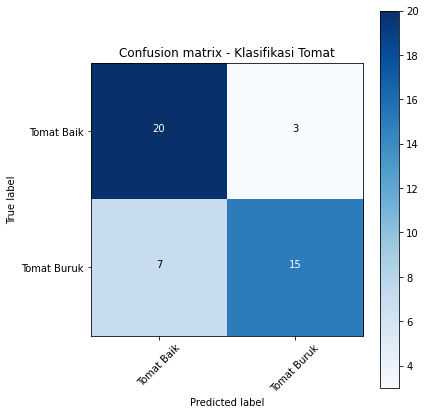

              precision    recall  f1-score   support

  Tomat Baik       0.74      0.87      0.80        23
 Tomat Buruk       0.83      0.68      0.75        22

    accuracy                           0.78        45
   macro avg       0.79      0.78      0.77        45
weighted avg       0.79      0.78      0.78        45



In [17]:
mlp_model.train()
mlp_model.validate()